Content:<br>

   * [1. Wave and spectrogram](#waveandspectrogram)
   * [2. MFCC](#mfcc)
   * [3. Spectrogram in 3d](#3d)

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

In [2]:
import sys
sys.path.insert(1, '../../')

from libs.utils import *
from libs.functions import *

In [3]:
train_audio_path = '../../../_inputs/raw/train/audio/'

There are two theories of a human hearing - place ( https://en.wikipedia.org/wiki/Place_theory_(hearing) (frequency-based) and temporal (https://en.wikipedia.org/wiki/Temporal_theory_(hearing) )
In speech recognition, I see two main tendencies - to input [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) (frequencies), and more sophisticated features MFCC - Mel-Frequency Cepstral Coefficients, PLP. You rarely work with raw, temporal data.

Let's visualize some recordings!

## 1. Wave and spectrogram:
<a id="waveandspectrogram"></a> 

Choose and read some file:

In [4]:
filename = '/yes/0a7c2a8d_nohash_0.wav'
# sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
samples, sample_rate = librosa.load(str(train_audio_path)+filename)

Define a function that calculates spectrogram.

Note, that we are taking logarithm of spectrogram values. It will make our plot much more clear, moreover, it is strictly connected to the way people hear.
We need to assure that there are no 0 values as input to logarithm.

Frequencies are in range (0, 8000) according to [Nyquist theorem](https://en.wikipedia.org/wiki/Nyquist_rate).

Let's plot it:

Text(0.5, 0, 'Seconds')

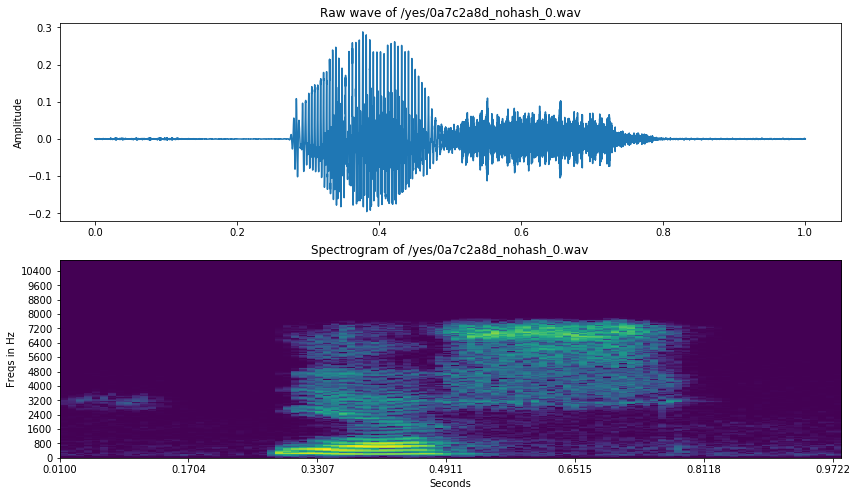

In [5]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), len(samples)), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

If we use spectrogram as an input features for NN, we have to remember to normalize features. (We need to normalize over all the dataset, here's example just for one, which doesn't give good *mean* and *std*!)

In [6]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

There is an interesting fact to point out. We have ~160 features for each frame, frequencies are between 0 and 8000. It means, that one feature corresponds to 50 Hz. However, [frequency resolution of the ear is 3.6 Hz within the octave of 1000 – 2000 Hz](https://en.wikipedia.org/wiki/Psychoacoustics) It means, that people are far more precise and can hear much smaller details than those represented by spectrograms like above.

## 2. MFCC
<a id="mfcc"></a> 

If you want to get to know some details about *MFCC* take a look at this great tutorial. [MFCC explained](http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/) You can see, that it is well prepared to imitate human hearing properties.

You can calculate *Mel power spectrogram* and *MFCC* using for example *librosa* python package.


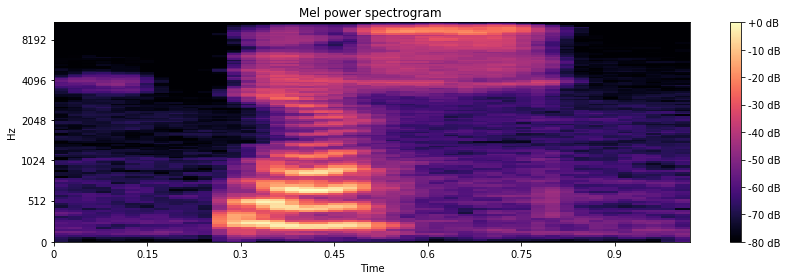

In [7]:
# From this tutorial
# https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128, fmax=8000)
# S = librosa.feature.melspectrogram(y= samples, sr=samplerate, n_mels=128, fmax=8000)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

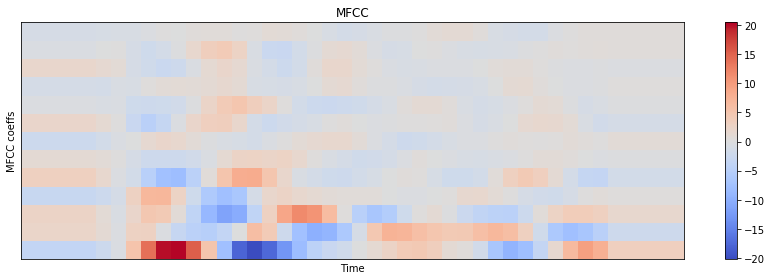

In [8]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In classical, but still state-of-the-art systems, *MFCC*  or similar features are taken as the input to the system instead of spectrograms.

However, in end-to-end (often neural-network based) systems, the most common input features are probably raw spectrograms, or mel power spectrograms. For example *MFCC* decorrelates features, but NNs deal with correlated features well. Also, if you'll understand mel filters, you may consider their usage sensible.a

It is your decision which to choose!

## 3. Spectrogram in 3d
<a id="3d"></a> 

By the way, times change, and the tools change. Have you ever seen spectrogram in 3d?

In [9]:
data = [go.Surface(x=times, y=freqs, z=spectrogram.T)]
layout = go.Layout(
title='Specgtrogram of "yes" in 3d',
scene = dict(
yaxis = dict(title='Frequncy', range=[freqs.min(),freqs.max()]),
xaxis = dict(title='Time', range=[times.min(),times.max()],),
zaxis = dict(title='Log amplitude'),
),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

(Don't know how to set axis ranges to proper values yet. I'd also like it to be streched like a classic spectrogram above..)